In [1]:
import numpy as np

from config.transformers import TimeWindowTransformer, LabelWindowExtractor

from config.regressors import NNRegressor
from config.loss_functions import RMSELoss
from config.models import ConvNN

from config.validation import RMSE, NMSE, cross_validate_NN

### Explanation of the new class NNRegressor

The class `NNRegressor` is defined in `regressors.py`. It is essentially a wrapper around a pytorch model that makes it compatible with scikit pipelines. Here is how to use it.

The `__init__` method of an `NNRegressor` instance takes in input:

* `model_class`: a pytorch model class (such as for example `ConvNN` contained in `models.py`);

* `model_parameters`: a dictionary containing the keyword arguments to be passed to `model_class` whenever the model is initialized;

* `loss_fnc`: a dictionary of named loss functions, taking in input numpy arrays and returning numbers; practically, this will always be `{'RMSE': RMSE, 'NMSE': NMSE}` where `RMSE, NMSE` are imported from `validation.py`

* `batch_size`, `learning_rate`, `max_epochs`, `patience`: these are pretty self-explanatory hyperparameters that are used to train the model.

Any instance of `NNRegressor` has three methods:
* `.fit`: takes in input a pair `(X,y)` of NUMPY arrays. The shape depends on the particular model class we are using, but we DO NOT pass the data split into sessions.

For example, in the case of `ConvNN` which works directly with time windows, `X` will have shape `(N, 8, 500)`, while `y` will have shape `(N, 51)`. `.fit` returns the `self` instance of `NNRegressor` (NOT the pytorch model!).

The "best" weights and biases of the neural network are internally saved in the attribute `.best_model` of the `NNRegressor` instance. In this case, "best" means that I take the weights and biases with lowest TRAINING loss function (that's the only way I could think of to avoid leakage).

The `patience` hyperparameter sets a possible early exit: if at training time the training loss is not improved in `patience` epochs, the training loop ends early.

* `.predict`: takes in input a NUMPY array `X` of the same shape of the `X` taken in input by `.fit`, and returns the predicted values of the model which uses the best weights and biases obtained at training time (for this reason, calling `.predict` before calling `.fit` or `.fit_with_validation` will throw an exception because `.best_model` is initialized to `None`).

* `.fit_with_validation`: this is a custom method which is not used by scikit pipelines, but is useful for us for architecture selection and hyperparameter tuning. This guy takes in input `(X_train, y_train, X_val, y_val)` which are NUMPY arrays of shape respectively `(N_train, ...), (N_train, 51), (N_val, ...), (N_val, 51)`.

This methods trains exactly the same model obtained by calling `.fit(X_train, y_train)`; however, it also computes and prints the average batch validation loss on the unseen data `(X_val, y_val)`.

Finally, this method returns a tuple `(train_losses, val_losses)` of numpy array of length equal to the number of epochs (which cannot exceed `max_epochs`, but can be smaller if the training loop exits earlier because of the patience mechanism).

### Explanation of the validation function cross_validate_NN

This function is in `validation.py` and it works similarly to `cross_validate_pipeline`. It takes in input an instance of `NNRegressor`, and the parameters `X_folds`, `Y_folds`, `metric_fns`, `n_folds`, `verbose` exactly as `cross_validate_pipeline`. So, in this case, `X_folds` and `Y_folds` are split into sessions.

For example, if the model we used to initialize our `NNRegressor` is `ConvNN`, the input of the `.fit` method should be a pair `X,y` with shape `(N, 8, 500)` and `(N, 51)` respectively. Therefore, the parameters `X_folds` and `Y_folds` of `cross_validate_NN` sholuld have shape `(n_folds, M, 8, 500)` and `(n_folds, M, 51)` respectively. `n_folds` is set to 4 by default, but it should be equal to the first dimension of `X_folds` and `Y_folds`.

The parameter `verbose` can take values 0,1,2,3. If we set it to 0,1,2 it does exactly the same that `cross_validate_pipeline` does. If we set it to `3`, the instance of `NNRegressor` calls `.fit_with_validation` rather than `.fit`, and therefore all the validation results are printed out, included the graphs showing the learning curves per fold.

This is easier to use than to explain!

### Loading, windowing

In [3]:
PATH = f'/Users/marco/PROJECTS/data/'
# PATH = r'C:\Users\gianm\Documents\Uni\Big Data\F422\project\data\\'
# PATH = r"D:/Uni/F422/F422/F422 EMG project data/"
DATASET = 'guided' # change this to guided/freemoves if needed

X = np.load(PATH + f'{DATASET}/{DATASET}_dataset_X.npy')
Y = np.load(PATH + f'{DATASET}/{DATASET}_dataset_Y.npy')

tw_extractor = TimeWindowTransformer(size = 500, step = 50)
label_extractor = LabelWindowExtractor(size = 500, step = 50)

X_windows = tw_extractor.transform(X)
Y_labels = label_extractor.transform(Y)

train_val_idx = [0,1,2,3,4]
# test_idx = 4

X_train_val_folds = X_windows[train_val_idx]
Y_train_val_folds = Y_labels[train_val_idx]

# X_test = X_windows[test_idx]
# Y_test = Y_labels[test_idx]

### Testing Marco's model

In [4]:
my_NNRegressor = NNRegressor(
    model_class=ConvNN,
    model_parameters={'end_dim': 51},
    loss_fnc=RMSELoss(),
    batch_size = 50,
    learning_rate = 0.001,
    max_epochs = 70,
    patience = 50
)

# results = cross_validate_NN(
#     my_NNRegressor,
#     X_train_val_folds,
#     Y_train_val_folds,
#     metric_fns={'RMSE': RMSE, 'NMSE': NMSE},
#     verbose=3)

In [6]:
X_train = X_train_val_folds.reshape(-1, *X_train_val_folds.shape[2:])
Y_train = Y_train_val_folds.reshape(-1, *Y_train_val_folds.shape[2:])

In [7]:
my_NNRegressor.fit(X_train, Y_train)

NNRegressor(batch_size=50, learning_rate=0.001,
            loss_fnc=RMSELoss(
  (mse): MSELoss()
), max_epochs=70,
            model_class=<class 'config.models.ConvNN'>,
            model_parameters={'end_dim': 51}, patience=50)

In [9]:
# predicting
X_test = np.load(PATH + f'{DATASET}/{DATASET}_testset_X.npy')
X_test = X_test.reshape(-1, *X_windows.shape[2:])

Y_guided_pred = my_NNRegressor.predict(X_test)

np.save('Y_guided_pred.npy', Y_guided_pred)

import pandas as pd

fname = 'dioporco.csv'

Y_pred_df = pd.DataFrame(Y_guided_pred)
Y_pred_df.to_csv(fname, index=False, header=None)

In [ ]:
# test on unseen data

# initialize the model
my_NNRegressor = NNRegressor(
    model_class=ConvNN,
    model_parameters={'end_dim': 51},
    loss_fnc=RMSELoss(),
    batch_size = 50,
    learning_rate = 0.001,
    max_epochs = 50,
    patience = 10
)

# train on the first four sessions
X_train = X_train_val_folds.reshape(-1, *X_train_val_folds.shape[2:])
Y_train = Y_train_val_folds.reshape(-1, *Y_train_val_folds.shape[2:])

my_NNRegressor.fit(X_train, Y_train)

# compute the prediction of the fifth session
Y_test_pred = my_NNRegressor.predict(X_test)

# compute the errors
print(RMSE(Y_test_pred, Y_test))
print(NMSE(Y_test_pred, Y_test))

KeyboardInterrupt: 

#### COVARIANCE/FEATURES COMBINED NN-MODEL

In [1]:
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import entropy, kurtosis
from config.transformers import *
import numpy as np
import pyriemann
import pywt

import torch
import torch.nn as nn
import torch.optim as optim



In [64]:



class WaveletBandExtractor(BaseEstimator, TransformerMixin):
    """
    Transformer that applies DWT to each channel of each window, 
    returning padded bands suitable for CNN input.
    
    Input shape:  (n_sessions, n_windows, n_channels, n_times)
    Output shape: (n_sessions, n_windows, n_channels, n_bands, max_band_len)
    or optionally flattened: (n_sessions, n_windows, n_channels * n_bands * max_band_len)
    """
    def __init__(self, wavelet='db4', level=3, flatten_output=False):
        self.wavelet = wavelet
        self.level = level
        self.flatten_output = flatten_output

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = np.asarray(X)
        n_sessions, n_windows, n_channels, n_times = X.shape
        X_reshaped = X.reshape(-1, n_channels, n_times)  # (total_windows, channels, times)

        # Compute max length of any band for padding
        sample_coeffs = pywt.wavedec(np.zeros(n_times), self.wavelet, level=self.level)
        max_len = max(len(b) for b in sample_coeffs)
        n_bands = len(sample_coeffs)

        band_array = np.zeros((X_reshaped.shape[0], n_channels, n_bands, max_len), dtype=np.float32)

        for i, window in enumerate(X_reshaped):
            for ch in range(n_channels):
                coeffs = pywt.wavedec(window[ch], self.wavelet, level=self.level)
                for b, band in enumerate(coeffs):
                    band_array[i, ch, b, :len(band)] = band  # pad shorter bands with 0

        # Restore session and window structure
        band_array = band_array.reshape(n_sessions, n_windows, n_channels, n_bands, max_len)

        if self.flatten_output:
            # Flatten last three dims for (n_sessions, n_windows, features)
            band_array = band_array.reshape(n_sessions, n_windows, -1)

        return band_array

    def set_output(self, *, transform=None):
        return super().set_output(transform=transform)


class WaveletFeatureTransformer(BaseEstimator, TransformerMixin):
    """
    Fully integrated transformer that performs DWT per channel and extracts statistical features.
    
    Input shape:  (..., n_channels, n_times)
    Output shape: (..., n_channels * n_bands * n_features)
    """
    def __init__(self, wavelet='db4', level=3):
        self.wavelet = wavelet
        self.level = level
        self.metrics = [
            lambda w: np.mean(w),
            lambda w: np.std(w),
            lambda w: np.sqrt(np.mean(w**2)),       # RMS
            lambda w: np.sum(w**2),                 # Energy
            lambda w: entropy(w**2 / (np.sum(w**2) + 1e-12)),  # Spectral entropy
            lambda w: kurtosis(w, bias=False)
        ]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = np.asarray(X).copy()
        orig_shape = X.shape
        X = X.reshape(-1, orig_shape[-2], orig_shape[-1])  # (n_samples, n_channels, n_times)

        feature_list = []
        for window in X:
            ch_feats = []
            for ch in window:
                ch = np.asarray(ch).copy()
                coeffs = pywt.wavedec(ch, self.wavelet, level=self.level)
                band_feats = [np.array([m(b) for m in self.metrics]) for b in coeffs]
                ch_feats.append(np.concatenate(band_feats))
            feature_list.append(np.concatenate(ch_feats))

        return np.array(feature_list).reshape(*orig_shape[:-2], -1)


    def set_output(self, *, transform=None):
        return super().set_output(transform=transform)


In [74]:
transformer = WaveletBandExtractor(wavelet='db4', level=3, flatten_output=False)
X_bands = transformer.transform(X_windows)  # shape: (5, 2696, 8 × n_bands × max_band_len)


In [72]:

class WaveletCNN(nn.Module):
    def __init__(self, output_dim=51, dropout=0.3):
        super().__init__()

        self.conv_layers = nn.Sequential(
            # Input: (batch, 8, 4, 253)
            nn.Conv2d(8, 32, kernel_size=(1, 5), stride=1, padding=(0, 2)),   # temporal conv
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Conv2d(32, 32, kernel_size=(2, 1), stride=1),  # band interaction
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Conv2d(32, 64, kernel_size=(1, 3), stride=1, padding=(0, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2)),  # reduce time dimension
        )

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # output shape: (batch, 64, 1, 1)

        self.fc = nn.Sequential(
            nn.Flatten(),            # (batch, 64)
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, output_dim)
        )

        self.net = nn.Sequential(*list(self.children()))

    def forward(self, x):
        # x shape: (batch, 8, 4, 253)
        x = self.conv_layers(x)
        x = self.global_pool(x)
        x = self.fc(x)
        return x
    
    def build(self):
        """Ensures compatibility with wrappers expecting a 'build()' method."""
        # We don't need to build anything explicitly here,
        # but we include a dummy pass to be consistent with models that do.
        pass


In [48]:

class SessionwiseTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, base_pipeline):
        self.base_pipeline = base_pipeline

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # X.shape: (n_sessions, n_windows, n_channels, size)
        features = []
        for sess in range(X.shape[0]):
            Xt = self.base_pipeline.fit_transform(X[sess])  # (n_windows, n_features)
            features.append(Xt)
        return np.array(features)  # (n_sessions, n_windows, n_features)



riemann_pipeline = Pipeline([
    ('cov', pyriemann.estimation.Covariances()),
    ('ts', pyriemann.tangentspace.TangentSpace(metric='riemann', tsupdate=True)),
])


combined_features = FeatureUnion([
    ("time_features", TimeDomainTransformer()),
    ("riemann_features", riemann_pipeline),
    ("wavelet_features", WaveletFeatureTransformer())
])



class StandardNN(nn.Module):
    def __init__(self, input_dim=132, hidden_layers=[2048, 1024, 512, 256], output_dim=51, dropout_rates=[0.1, 0.2, 0.1, 0.2, 0.1]):
        super().__init__()
        layers = []
        in_features = input_dim
        for hidden_dim, drop in zip(hidden_layers, dropout_rates):
            layers += [
                nn.Linear(in_features, hidden_dim),
                nn.ReLU(),
                nn.Dropout(drop)
            ]
            in_features = hidden_dim
        layers.append(nn.Linear(in_features, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        if x.ndim == 1:
            x = x.unsqueeze(0)
        return self.net(x)
    
    def build(self):
        """Ensures compatibility with wrappers expecting a 'build()' method."""
        # We don't need to build anything explicitly here,
        # but we include a dummy pass to be consistent with models that do.
        _ = self.forward(torch.zeros(1, self.net[0].in_features))

tw_extractor = TimeWindowTransformer(size = 500, step = 100)
label_extractor = LabelWindowExtractor(size = 500, step = 100)
sessionwise_combined = SessionwiseTransformer(combined_features)


X_windows = tw_extractor.transform(X)
Y_labels = label_extractor.transform(Y)

# Resulting shape: (n_sessions, n_windows, total_features)

X_features = sessionwise_combined.transform(X_windows)

FOLD 1/4


RuntimeError: mat1 and mat2 shapes cannot be multiplied (512x8096 and 324x512)

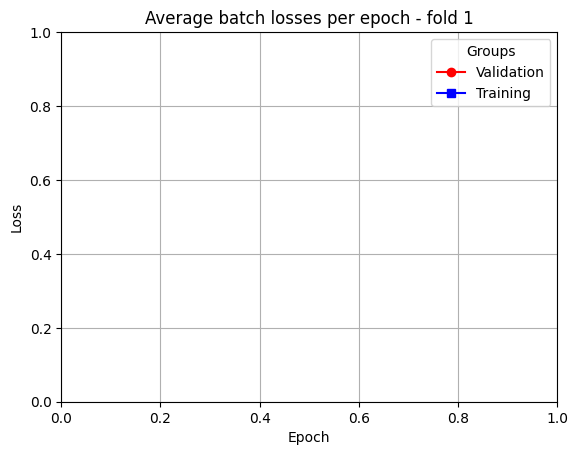

In [66]:


train_val_idx = [0,1,2,3]
test_idx = 4

X_train_val_folds = X_features[train_val_idx]
Y_train_val_folds = Y_labels[train_val_idx]

X_test = X_windows[test_idx]
Y_test = Y_labels[test_idx]


model_configuration = {'output_dim': 51,
                       'input_dim':324,
                       'hidden_layers': [512, 256, 256, 256, 128, 128],
                       'dropout_rates':[0.01, 0.01, 0.01, 0.01, 0.01, 0.01]}

my_NNRegressor = NNRegressor(
    model_class=StandardNN,
    model_parameters=model_configuration,
    loss_fnc=RMSELoss(),
    batch_size = 512,
    learning_rate = 0.003,
    max_epochs = 250,
    patience = 10
)

results = cross_validate_NN(
    my_NNRegressor,
    X_train_val_folds,
    Y_train_val_folds,
    metric_fns={'RMSE': RMSE, 'NMSE': NMSE},
    verbose=3)

FOLD 1/4
Epoch 001 | Train Loss: 26.8785 | Val Loss: 23.7963 | 
Epoch 002 | Train Loss: 22.6984 | Val Loss: 18.3723 | 
Epoch 003 | Train Loss: 15.0384 | Val Loss: 13.1382 | 
Epoch 004 | Train Loss: 12.0818 | Val Loss: 13.1182 | 
Epoch 005 | Train Loss: 11.6324 | Val Loss: 13.3975 | 
Epoch 006 | Train Loss: 11.4814 | Val Loss: 13.4621 | 
Epoch 007 | Train Loss: 11.3663 | Val Loss: 14.0518 | 
Epoch 008 | Train Loss: 11.3056 | Val Loss: 13.9338 | 
Epoch 009 | Train Loss: 11.2371 | Val Loss: 13.9823 | 
Epoch 010 | Train Loss: 11.1893 | Val Loss: 13.3482 | 
Epoch 011 | Train Loss: 11.1701 | Val Loss: 13.3964 | 
Epoch 012 | Train Loss: 11.1002 | Val Loss: 12.5058 | 
Epoch 013 | Train Loss: 11.0576 | Val Loss: 12.8168 | 
Epoch 014 | Train Loss: 10.9880 | Val Loss: 12.0848 | 
Epoch 015 | Train Loss: 10.9684 | Val Loss: 13.3892 | 
Epoch 016 | Train Loss: 10.9459 | Val Loss: 12.9272 | 
Epoch 017 | Train Loss: 10.9101 | Val Loss: 12.1866 | 
Epoch 018 | Train Loss: 10.8302 | Val Loss: 12.6447 | 
E

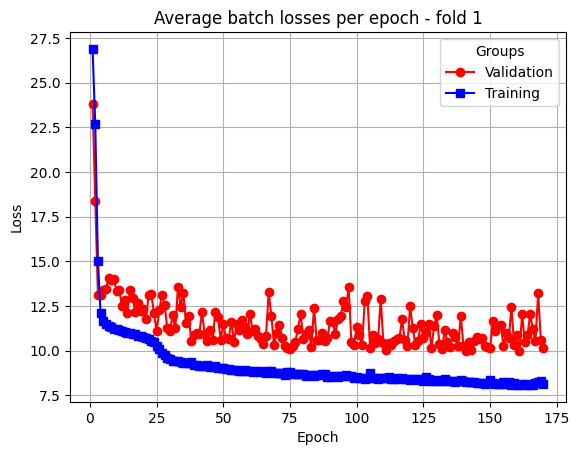

FOLD 2/4
Epoch 001 | Train Loss: 24.4454 | Val Loss: 30.1765 | 
Epoch 002 | Train Loss: 20.4370 | Val Loss: 23.3582 | 
Epoch 003 | Train Loss: 13.8722 | Val Loss: 13.5604 | 
Epoch 004 | Train Loss: 11.4977 | Val Loss: 16.8238 | 
Epoch 005 | Train Loss: 11.1364 | Val Loss: 17.2637 | 
Epoch 006 | Train Loss: 10.9928 | Val Loss: 17.0251 | 
Epoch 007 | Train Loss: 10.8924 | Val Loss: 18.5273 | 
Epoch 008 | Train Loss: 10.7850 | Val Loss: 16.8276 | 
Epoch 009 | Train Loss: 10.6907 | Val Loss: 16.3257 | 
Epoch 010 | Train Loss: 10.6450 | Val Loss: 18.4180 | 
Epoch 011 | Train Loss: 10.5616 | Val Loss: 17.0012 | 
Epoch 012 | Train Loss: 10.5187 | Val Loss: 16.6238 | 
Epoch 013 | Train Loss: 10.5030 | Val Loss: 15.8521 | 
Epoch 014 | Train Loss: 10.4279 | Val Loss: 15.4366 | 
Epoch 015 | Train Loss: 10.4134 | Val Loss: 16.4086 | 
Epoch 016 | Train Loss: 10.4093 | Val Loss: 16.5006 | 
Epoch 017 | Train Loss: 10.3386 | Val Loss: 15.2297 | 
Epoch 018 | Train Loss: 10.3351 | Val Loss: 16.9748 | 
E

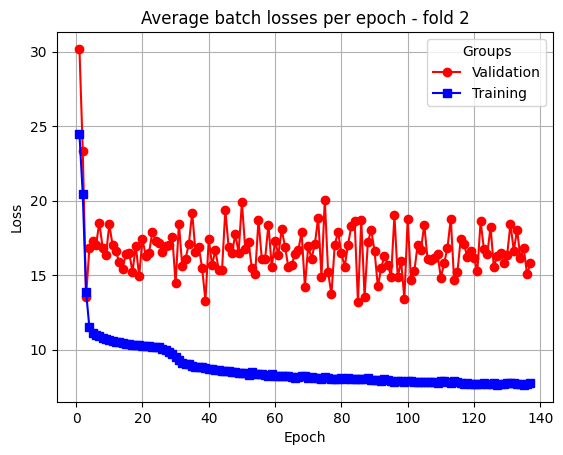

FOLD 3/4
Epoch 001 | Train Loss: 26.3536 | Val Loss: 25.5734 | 
Epoch 002 | Train Loss: 22.0408 | Val Loss: 19.6055 | 
Epoch 003 | Train Loss: 14.3738 | Val Loss: 14.3645 | 
Epoch 004 | Train Loss: 11.8245 | Val Loss: 12.1392 | 
Epoch 005 | Train Loss: 11.5370 | Val Loss: 12.1820 | 
Epoch 006 | Train Loss: 11.4419 | Val Loss: 11.8954 | 
Epoch 007 | Train Loss: 11.3642 | Val Loss: 12.4939 | 
Epoch 008 | Train Loss: 11.3348 | Val Loss: 12.8442 | 
Epoch 009 | Train Loss: 11.2557 | Val Loss: 13.3116 | 
Epoch 010 | Train Loss: 11.1751 | Val Loss: 13.8616 | 
Epoch 011 | Train Loss: 11.1133 | Val Loss: 14.2844 | 
Epoch 012 | Train Loss: 11.0467 | Val Loss: 13.5844 | 
Epoch 013 | Train Loss: 10.9765 | Val Loss: 13.5945 | 
Epoch 014 | Train Loss: 10.9036 | Val Loss: 14.1733 | 
Epoch 015 | Train Loss: 10.8401 | Val Loss: 12.7955 | 
Epoch 016 | Train Loss: 10.8643 | Val Loss: 11.8238 | 
Epoch 017 | Train Loss: 10.7455 | Val Loss: 13.1592 | 
Epoch 018 | Train Loss: 10.6890 | Val Loss: 11.7288 | 
E

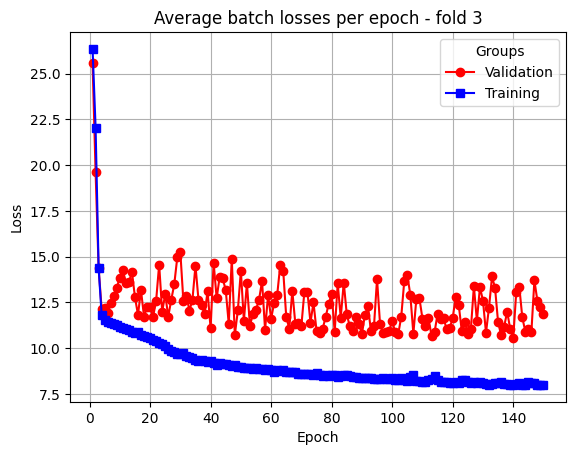

FOLD 4/4
Epoch 001 | Train Loss: 27.2363 | Val Loss: 22.5777 | 
Epoch 002 | Train Loss: 23.3213 | Val Loss: 16.9284 | 
Epoch 003 | Train Loss: 15.9801 | Val Loss: 11.4540 | 
Epoch 004 | Train Loss: 12.4658 | Val Loss: 10.8281 | 
Epoch 005 | Train Loss: 11.9110 | Val Loss: 12.3581 | 
Epoch 006 | Train Loss: 11.7509 | Val Loss: 10.9032 | 
Epoch 007 | Train Loss: 11.6206 | Val Loss: 11.9081 | 
Epoch 008 | Train Loss: 11.5369 | Val Loss: 12.9293 | 
Epoch 009 | Train Loss: 11.4314 | Val Loss: 13.1263 | 
Epoch 010 | Train Loss: 11.3506 | Val Loss: 11.9093 | 
Epoch 011 | Train Loss: 11.2740 | Val Loss: 11.5159 | 
Epoch 012 | Train Loss: 11.1895 | Val Loss: 11.1761 | 
Epoch 013 | Train Loss: 11.1082 | Val Loss: 11.1664 | 
Epoch 014 | Train Loss: 11.0451 | Val Loss: 11.5508 | 
Epoch 015 | Train Loss: 10.9802 | Val Loss: 10.9279 | 
Epoch 016 | Train Loss: 10.9170 | Val Loss: 10.9068 | 
Epoch 017 | Train Loss: 10.8826 | Val Loss: 12.6915 | 
Epoch 018 | Train Loss: 10.7010 | Val Loss: 11.2898 | 
E

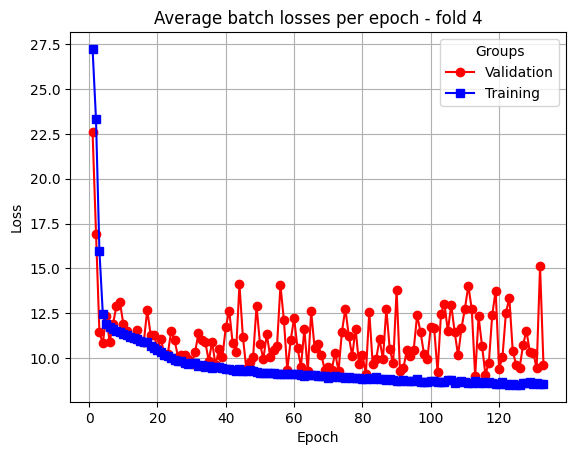


Average Scores across folds:
RMSE: train=8.1354, val=11.6318
NMSE: train=0.4024, val=0.9191


In [75]:
train_val_idx = [0,1,2,3]
test_idx = 4

X_train_val_folds = X_bands[train_val_idx]
Y_train_val_folds = Y_labels[train_val_idx]

X_test = X_bands[test_idx]
Y_test = Y_labels[test_idx]


model_configuration = {'output_dim': 51,
                       'dropout':0.1}

my_NNRegressor = NNRegressor(
    model_class=WaveletCNN,
    model_parameters=model_configuration,
    loss_fnc=RMSELoss(),
    batch_size = 512,
    learning_rate = 0.002,
    max_epochs = 250,
    patience = 10
)

results = cross_validate_NN(
    my_NNRegressor,
    X_train_val_folds,
    Y_train_val_folds,
    metric_fns={'RMSE': RMSE, 'NMSE': NMSE},
    verbose=3)